In [1]:
import numpy as np
import pandas as pd
from skimage.transform import resize
import tqdm
import matplotlib.pyplot as plt
data_path = '/home/richard/Documents/dslab/data/'

### Prepare patches

In [2]:
# load data set in .npy format
X = np.load(data_path + '03_features/fulldataset_small_1.npy', allow_pickle=True)
X_df = pd.DataFrame(X)

In [18]:
pd.DataFrame(X_df[0].iloc[0]).head()

,droplet_id,frame,center_row,center_col,radius,nr_cells,patch,cell_signals
0,0,0,595,114,21,0,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","Empty DataFrame Columns: [cell_id, center_row,..."
1,1,0,1233,4140,21,0,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","Empty DataFrame Columns: [cell_id, center_row,..."
2,2,0,2395,2659,21,0,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","Empty DataFrame Columns: [cell_id, center_row,..."
3,3,0,2644,3738,21,0,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","Empty DataFrame Columns: [cell_id, center_row,..."
4,4,0,1665,1987,22,0,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","Empty DataFrame Columns: [cell_id, center_row,..."


In [75]:
len(X_df[0])

8

### Prepare tracking  

In [3]:
# read csv into dataframe
tracking_df = pd.read_csv(data_path + '05_results/tracking_small_1.csv')
initial_len = len(tracking_df)
print('Initial length: ', initial_len)

Initial length:  64077


In [9]:
# there is no Nans here, was checked
tracking_df.head()

,framePrev,frameNext,dropletIdPrev,dropletIdNext
0,0,1,0,3473
1,0,1,1,7477
2,0,1,2,4783
3,0,1,3,7496
4,0,1,4,8326


### Debugging

In [4]:
def create_mapping_df(patches_df, tracking_df, distance=10):
    """
    Creates a DataFrame mapping droplet patches across frames.
    
    The DataFrame contains only correctly (this is an assumption) tracked droplets. Each column represents a frame, 
    named 'patchN', where N is the frame number and the values are the droplet patches in that frame.
    
    Parameters:
    patches_df (DataFrame): DataFrame containing droplet patches.
    tracking_df (DataFrame): DataFrame containing tracking information.
    regions (optional): Specific regions to consider.

    Returns:
    DataFrame: A DataFrame with droplet patches mapped across frames.
    """
    mapping = None
    columns = ["dropletIdNext"]
    num_frames = len(patches_df[0])
    
    # use tqdm to label the progress bar
    for i in tqdm.tqdm(range(num_frames-1), desc="Creating DataFrame..."):

        # get frames
        frame2 = pd.DataFrame(patches_df[0].iloc[i+1])

        # drop nan values and rows with no cells
        frame2 = frame2.dropna()
        frame2 = frame2[frame2["nr_cells"] > 0]
        frame2 = frame2.rename(columns={'patch': 'patch' + str(i+1),
                                        'center_row': 'x' + str(i+1),
                                        'center_col': 'y' + str(i+1)})

        if mapping is None:
            
            mapping = tracking_df[tracking_df["framePrev"] == i]

            # drop nan values and rows with no cells
            frame1 = pd.DataFrame(patches_df[0].iloc[i])
            frame1 = frame1.dropna()
            frame1 = frame1[frame1["nr_cells"] > 0]

            frame1 = frame1.rename(columns={'patch': 'patch' + str(i), 
                                            'center_row': 'x' + str(i), 
                                            'center_col': 'y' + str(i)})
            columns.append('patch' + str(i))
            columns.append('x' + str(i))
            columns.append('y' + str(i))

            mapping = mapping.merge(frame1, how="inner", left_on="dropletIdPrev", right_on="droplet_id")
        
        else:
            # join next frame
            mapping = mapping.merge(tracking_df[tracking_df["framePrev"] == i], \
                                    how="inner", left_on="dropletIdNext", \
                                    right_on="dropletIdPrev",  suffixes=("_x", None))

        columns.append('patch' + str(i+1))
        columns.append('x' + str(i+1))
        columns.append('y' + str(i+1))

        mapping = mapping.merge(frame2, how="inner", \
                                left_on="dropletIdNext", \
                                right_on="droplet_id")

        mapping = mapping.dropna()

        # drop all rows where abs(center_x - center > 10)
        mapping = mapping[abs(mapping["x" + str(i)] - mapping["x" + str(i+1)]) < distance]
        mapping = mapping[abs(mapping["y" + str(i)] - mapping["y" + str(i+1)]) < distance]

        mapping = mapping[columns]
    
    columns = columns[1:]

    return mapping[columns]

def resize_patch_columns(df, num_frames):
    """
    Resizes all patches in the DataFrame to 40x40.
    
    Each patch in the DataFrame is resized to a 2D 40x40 patch and stored in a numpy array.
    
    Parameters:
    df (DataFrame): The DataFrame containing patches to be resized.

    Returns:
    numpy array: The resulting numpy array containing resized patches.
    """
    for i in tqdm.tqdm(range(num_frames), desc="Resizing patches..."):
        for j in range(len(df)):
            patch = df["patch" + str(i)].iloc[j]
            patch = resize(patch, (2,40,40))
            # updated dataframe
            df.at[j, "patch" + str(i)] = patch

    return df

def local_negatives(mapped_patches, num_frames):

    # create empty index list
    indices = np.empty((len(mapped_patches) * (num_frames - 1), 128), dtype=np.int16)

    # iterate over frames:
    for i in tqdm.tqdm(range(num_frames-1), desc="Creating local negatives..."):
        # iterate over droplets in frame i
        next_x = np.array(mapped_patches["x" + str(i+1)])
        next_y = np.array(mapped_patches["y" + str(i+1)])
        for j in range(len(mapped_patches)):
            # get positions 
            curr_x = np.array(mapped_patches["x" + str(i)].iloc[j])
            curr_y = np.array(mapped_patches["y" + str(i)].iloc[j])

            # exclude j-th entry from next
            next_x_temp = np.delete(next_x, j)
            next_y_temp = np.delete(next_y, j)

            # calculate distances
            distances = np.sqrt((curr_x - next_x_temp)**2 + (curr_y - next_y_temp)**2)

            # get 128 closest droplets
            closest = np.argsort(distances)[:128]

            # add length of list to closest
            closest = closest + len(mapped_patches) * (i + 1)

            # update indices
            indices[j + (i * len(mapped_patches)), :] = closest

    return indices

def turn_to_numpy(df, num_frames):
    """
    Converts a DataFrame into a numpy array.
    
    Each column of the DataFrame is resized and concatenated to form the final numpy array.
    
    Parameters:
    df (DataFrame): The DataFrame to be converted.

    Returns:
    numpy array: The resulting numpy array after conversion.
    """
    
    dataset = np.empty((num_frames * len(df), 2, 40, 40), dtype=np.float32)

    for i in tqdm.tqdm(range(num_frames), desc="Flatten to numpy array..."):
        for j in range(len(df)):
            dataset[j + i * len(df)] = df["patch" + str(i)].iloc[j]

    return dataset

def get_labels(mapped_patches, num_frames):

    labels = np.empty((len(mapped_patches) * (num_frames - 1),), dtype=np.int16)

    for i in range(num_frames-1):
        for j in range(len(mapped_patches)):
            labels[j + (i * len(mapped_patches))] = j + (i+1) * len(mapped_patches)

    return labels

In [5]:
import tqdm

res = create_mapping_df(X_df, tracking_df)

Creating DataFrame...:   0%|          | 0/8 [00:00<?, ?it/s]

Creating DataFrame...: 100%|██████████| 8/8 [00:16<00:00,  2.07s/it]


In [6]:
res.head()

,patch0,x0,y0,patch1,x1,y1,patch2,x2,y2,patch3,...,y5,patch6,x6,y6,patch7,x7,y7,patch8,x8,y8
0,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",210,2291,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",213,2286,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",213,2286,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",...,2286,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",213,2286,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",213,2287,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",213,2287
1,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1389,1164,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1383,1161,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1382,1160,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",...,1161,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1382,1161,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1382,1161,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1382,1162
2,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",456,246,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",456,239,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",455,239,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",...,239,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",456,240,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",456,240,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",457,247
3,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",87,3748,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",88,3749,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",87,3750,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",...,3750,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",87,3750,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",87,3750,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",87,3751
5,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1896,3386,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1895,3387,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1895,3387,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",...,3387,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1895,3388,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1895,3388,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1895,3388


In [7]:
# reset indices of res
res = res.reset_index(drop=True)

In [9]:
res.head()

,patch0,x0,y0,patch1,x1,y1,patch2,x2,y2,patch3,...,y5,patch6,x6,y6,patch7,x7,y7,patch8,x8,y8
0,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",210,2291,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",213,2286,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",213,2286,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",...,2286,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",213,2286,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",213,2287,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",213,2287
1,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1389,1164,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1383,1161,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1382,1160,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",...,1161,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1382,1161,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1382,1161,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1382,1162
2,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",456,246,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",456,239,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",455,239,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",...,239,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",456,240,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",456,240,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",457,247
3,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",87,3748,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",88,3749,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",87,3750,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",...,3750,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",87,3750,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",87,3750,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",87,3751
4,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1896,3386,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1895,3387,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1895,3387,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",...,3387,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1895,3388,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1895,3388,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1895,3388


In [11]:
len(res)

2106

In [73]:
mapping = resize_patch_columns(res, 8)
ind = local_negatives(mapping, 8)
test = turn_to_numpy(mapping, 8)
labels = get_labels(mapping, 8)

Resizing patches...:   0%|          | 0/8 [00:00<?, ?it/s]

Flatten to numpy array...: 100%|██████████| 8/8 [00:01<00:00,  7.02it/s]


### Before Permutation

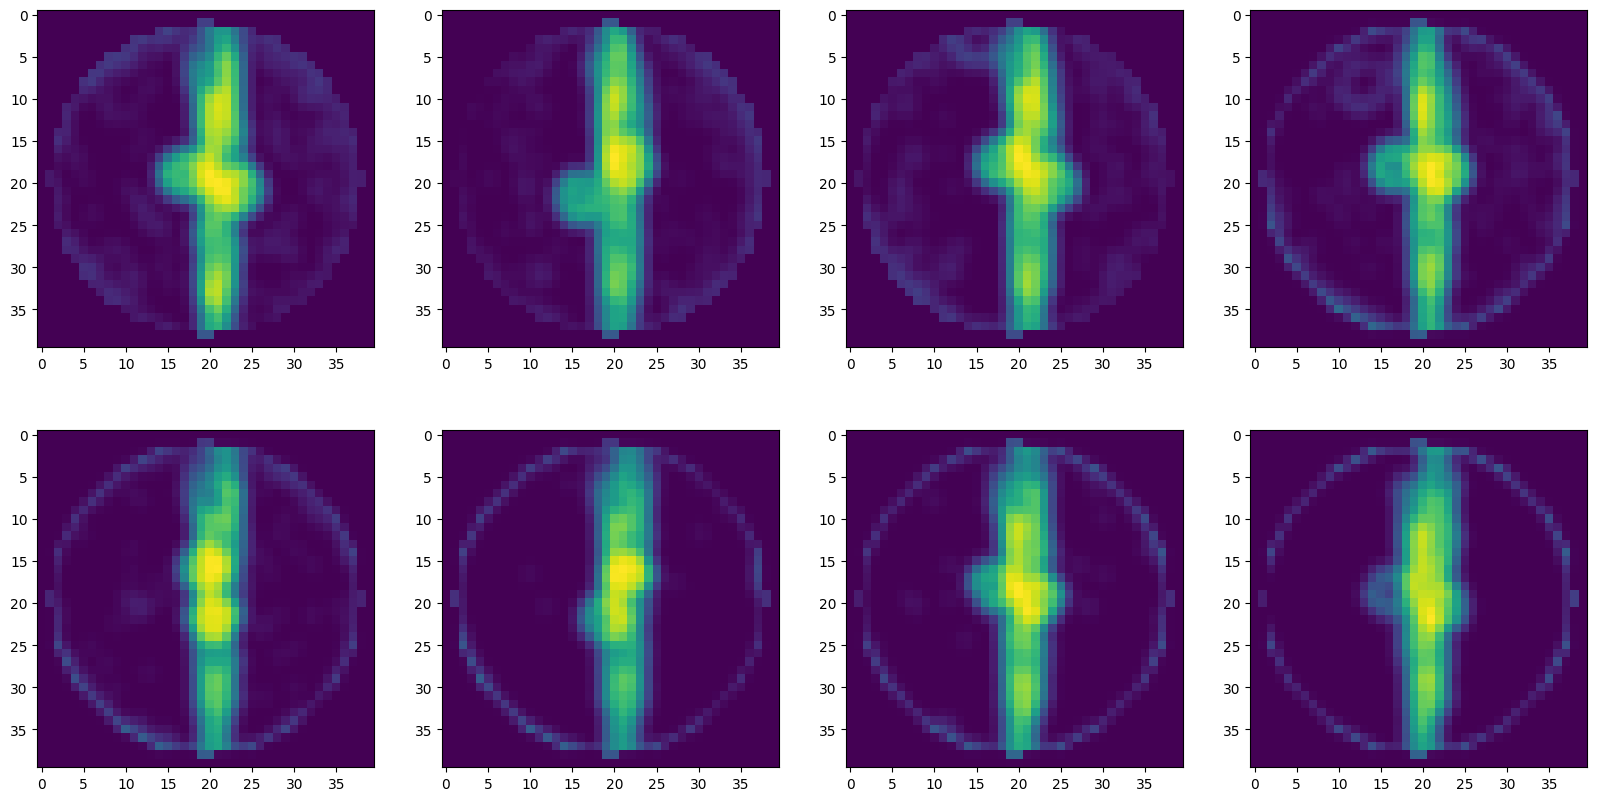

In [74]:
# check for correct mapping
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(8):
    # plot patch 0 across all frames
    ax[i//4, i%4].imshow(test[3 + i * len(mapping)][0])

# save figure to file
fig.savefig('test.png')

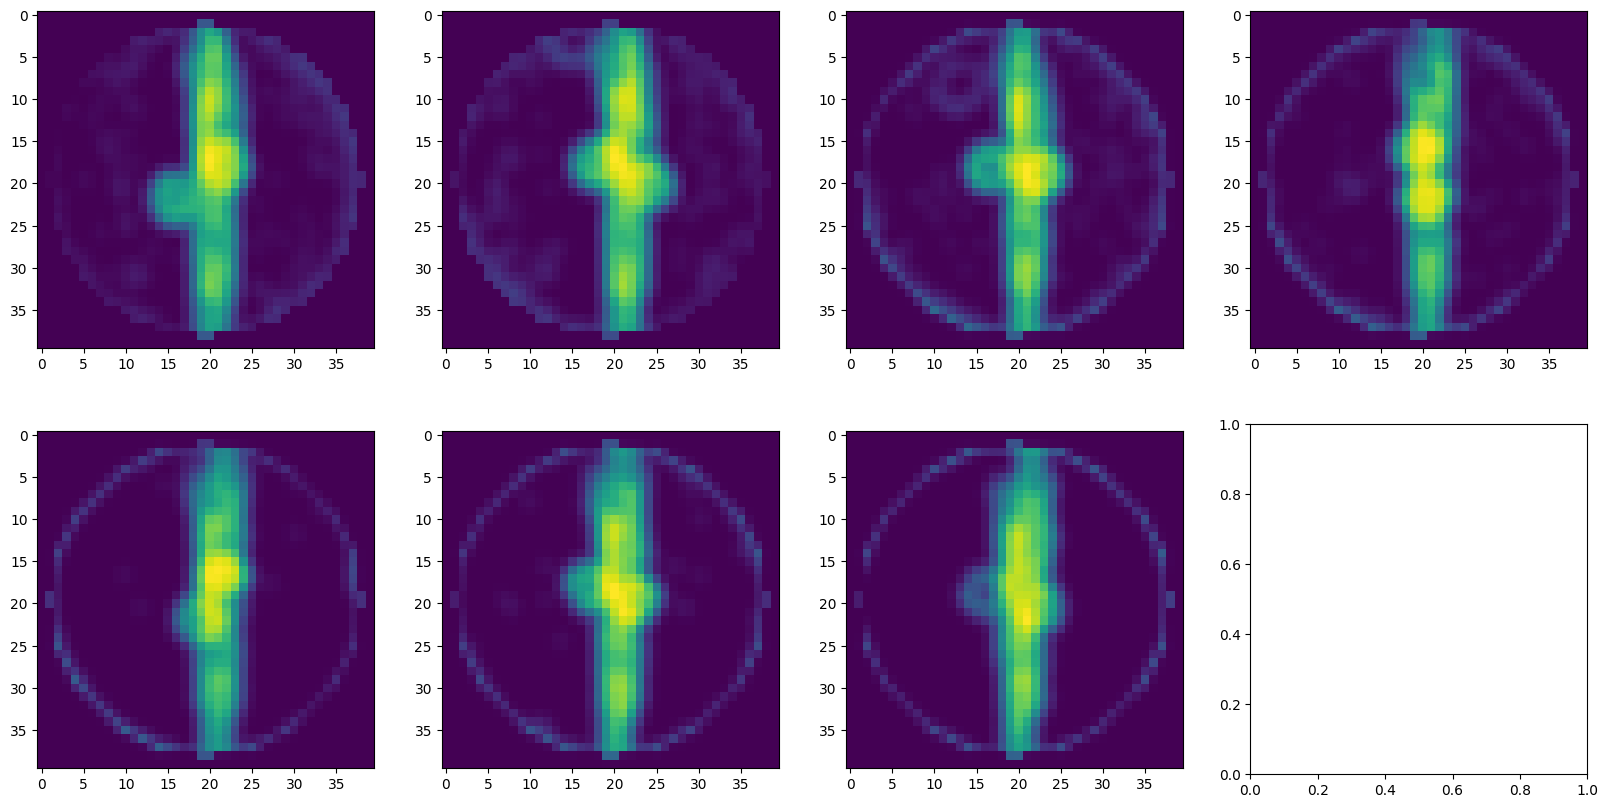

In [77]:
# plot 8 labels
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(7):
    # plot patch 0 across all frames
    ax[i//4, i%4].imshow(test[labels[3 + i * len(mapping)]][0])

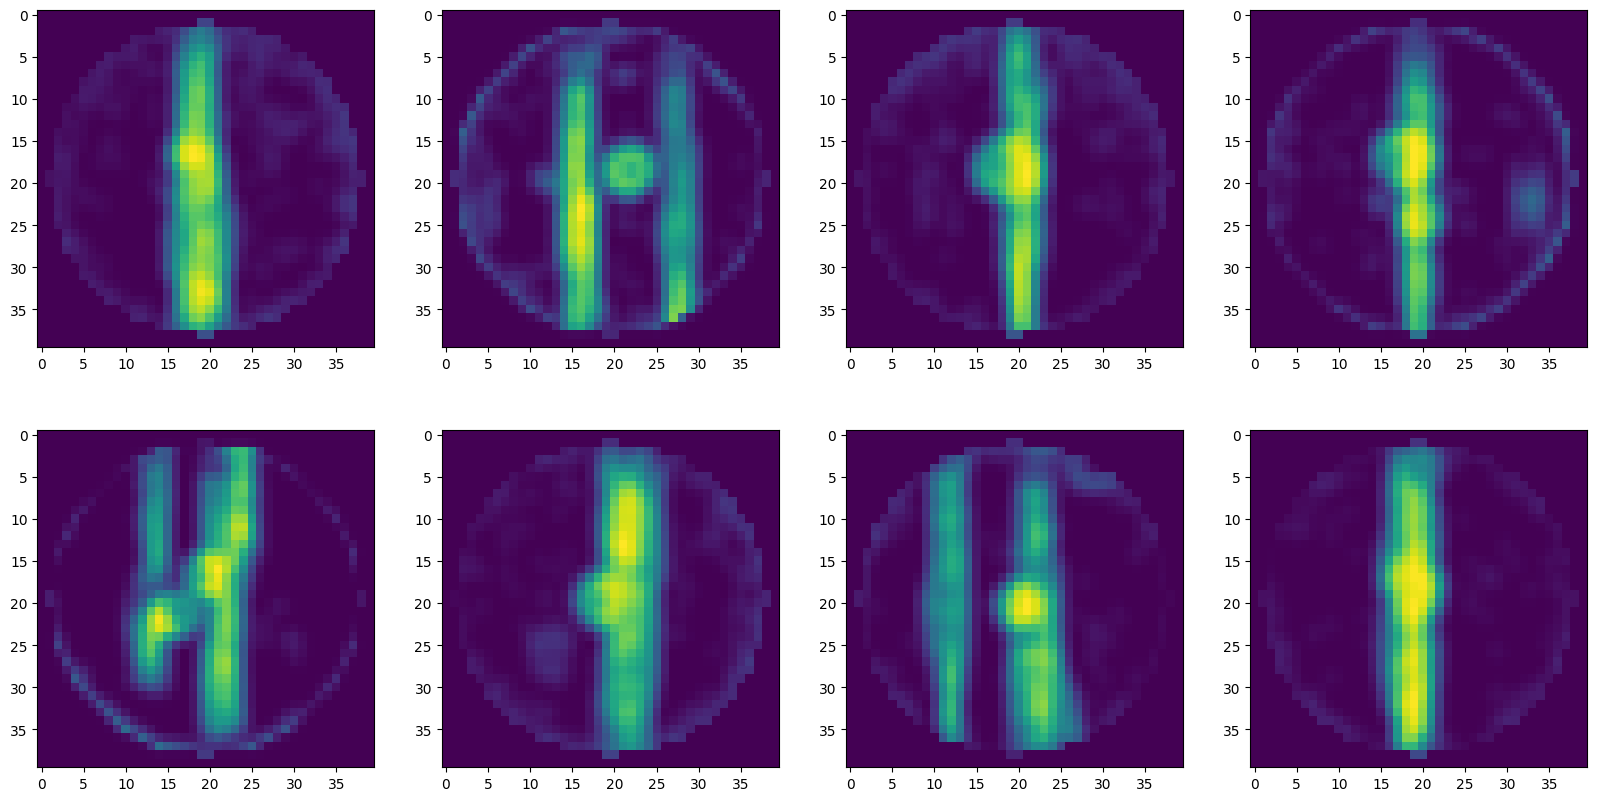

In [76]:
# plot 8 negatives
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(8):
    # plot patch 0 across all frames
    ax[i//4, i%4].imshow(test[ind[3][i]][0])

### Permutation

In [84]:
def turn_into_right_format(mapped_patches, num_frames):

    # get negative indices
    neg_indices = local_negatives(mapped_patches, num_frames)

    # flatten patches into numpy array
    dataset = turn_to_numpy(mapped_patches, num_frames)

    # get labels
    labels = get_labels(mapped_patches, num_frames)

    # apply same random shuffling to dataset and labels
    permutation = np.arange(len(dataset))
    permutation[:len(labels)] = np.random.permutation(len(labels))

    # apply permutation to dataset and labels
    dataset = dataset[permutation]
    labels = labels[permutation[:len(labels)]]
    neg_indices = neg_indices[permutation[:len(labels)]]

    for i in tqdm.tqdm(range(len(labels)), desc="Applying permutation to indices..."):
        labels[i] = np.where(permutation == labels[i])[0][0]
        for j in range(len(neg_indices[i])):
            neg_indices[i][j] = np.where(permutation == neg_indices[i][j])[0][0]
        
    print(np.where(permutation == 3)[0])

    return dataset, labels, neg_indices

In [85]:
test, labels, ind = turn_into_right_format(mapping, 8)

Applying permutation to indices...: 100%|██████████| 14742/14742 [00:51<00:00, 288.65it/s]

[6904]


In [86]:
after = 6904

### After Permutation

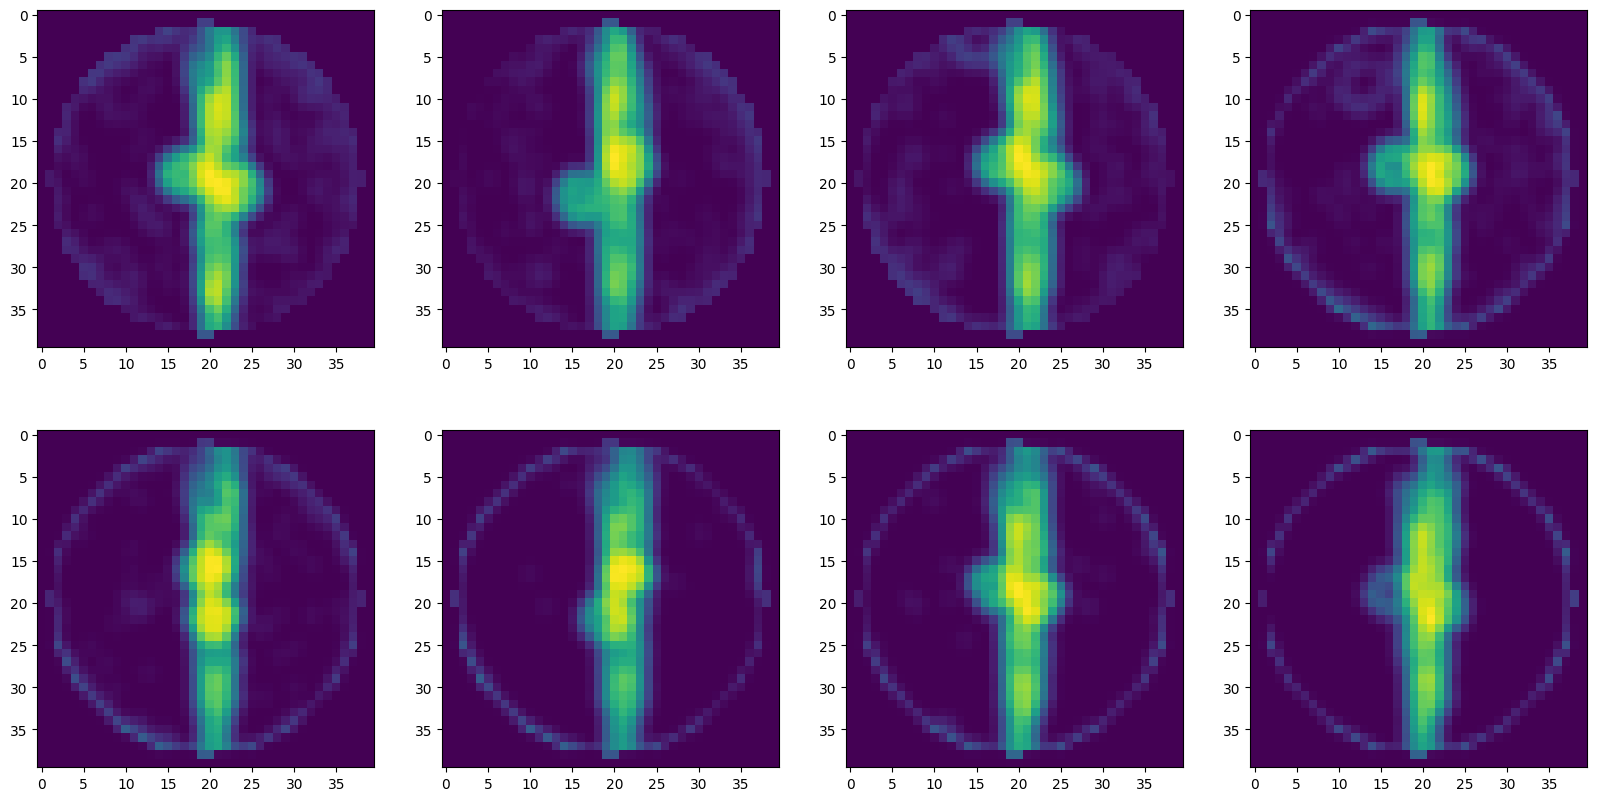

In [87]:
# check for correct labels
next = after
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(8):
    # plot patch 0 across all frames
    ax[i//4, i%4].imshow(test[next][0])
    if i < 7:
        next = labels[next]

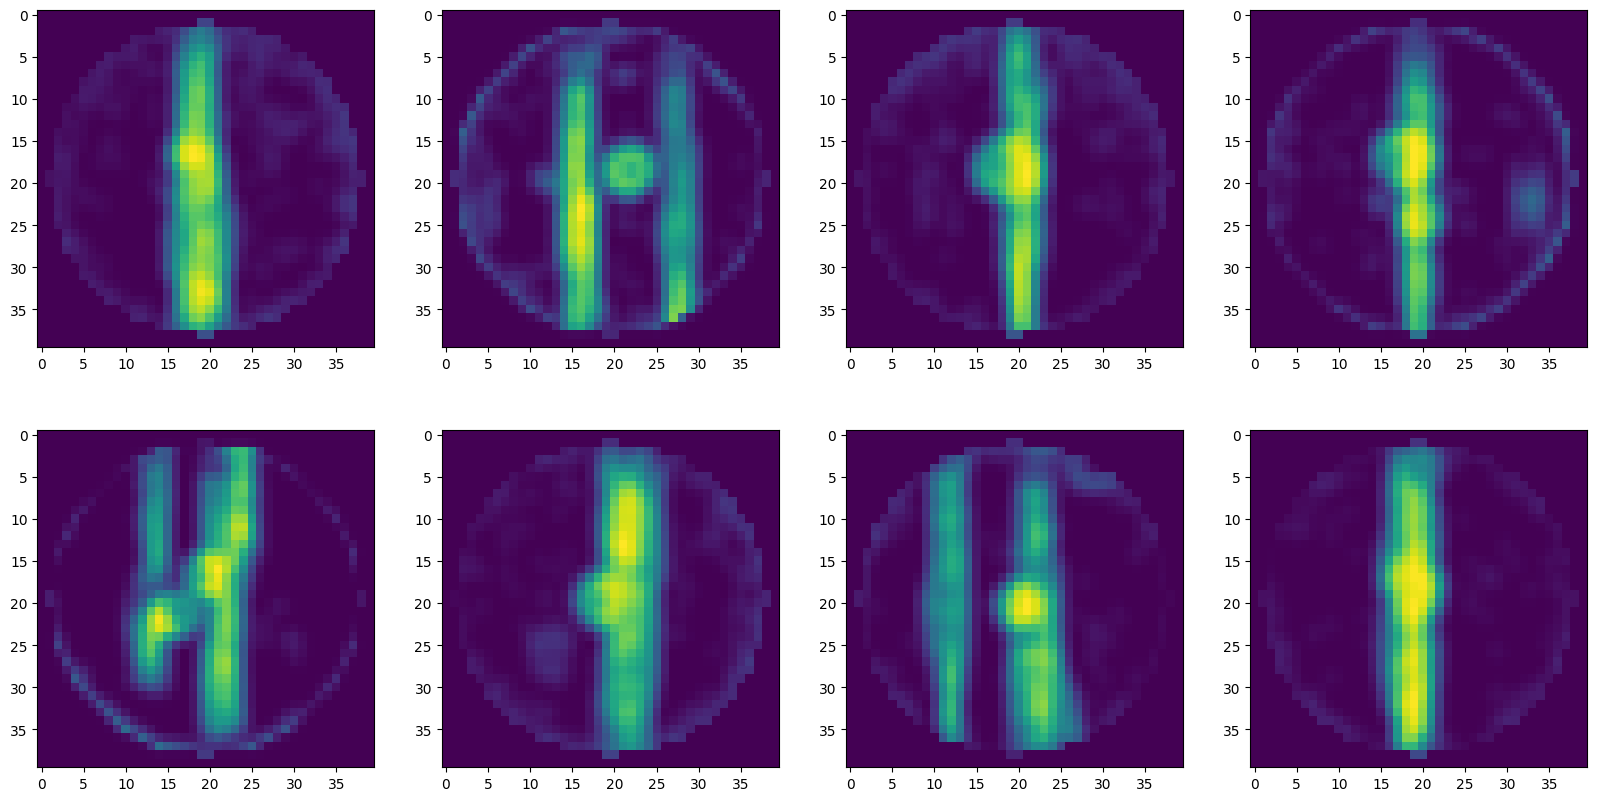

In [88]:
# check for correct negatives
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(8):
    # plot patch 0 across all frames
    ax[i//4, i%4].imshow(test[ind[after][i]][0])